###  Chemiscope Auto

This example performs dimensionality reduction and visualization analysis on molecular data from the QM9 dataset using techniques such as PCA, UMAP, t-SNE,
and ICA. It calculates features like MACE-OFF, MACE-MP, and SOAP for the molecular structures, then applies dimensionality reduction methods to explore their intrinsic structures.

First, we import all the necessary packages:

In [340]:
import os
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
import umap
from tqdm.auto import tqdm

import chemiscope
from load_atoms import load_dataset
from mace.calculators import mace_off, mace_mp
import rascaline
from rascaline.calculators import SoapPowerSpectrum
from metatensor import mean_over_samples

Load QM9

In [305]:
frames = load_dataset("QM9")
frames = frames[:20]

Output()

### Deminsionality reduction technics

In [139]:
methods = ["PCA", "UMAP", "TSNE", "ICA"]

In [140]:
def dimensionality_reduction_analysis(descriptors, method="PCA"):
    if method not in methods:
        raise ValueError("Invalid method name.")

    start_time = time.time()

    if method == "PCA":
        reducer = PCA(n_components=2)

    elif method == "UMAP":
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=15,
            min_dist=0.1,
            metric="euclidean",
            target_metric="categorical",
        )

    elif method == "TSNE":
        perplexity = min(30, descriptors.shape[0] - 1)
        reducer = TSNE(n_components=2, perplexity=perplexity)

    elif method == "ICA":
        reducer = FastICA(n_components=2)

    X_reduced = reducer.fit_transform(descriptors)

    execution_time = time.time() - start_time
    print(f"{method} execution time: {execution_time:.2f} seconds")
    return X_reduced, execution_time

### Dimensionality Reduction on every 25 structures

#### Computation of features

Initialize MACE calculators

In [141]:
descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
calculator_mace_off = mace_off(**descriptor_opt)
calculator_mace_mp = mace_mp(**descriptor_opt)

Using MACE-OFF23 MODEL for MACECalculator with /home/chorna/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using Materials Project MACE for MACECalculator with /home/chorna/.cache/mace/46jrkm3v
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


Initialize SOAP calculator

In [142]:
hypers = {
    "cutoff": 4,
    "max_radial": 6,
    "max_angular": 4,
    "atomic_gaussian_width": 0.7,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"Gto": {"accuracy": 1e-6}},
    "center_atom_weight": 1.0,
}
calculator_soap = SoapPowerSpectrum(**hypers)

Calculate MACE-OFF and MACE-MP features

In [143]:
def compute_mace_features(frames, calculator, invariants_only=False):
    descriptors = []
    for frame in tqdm(frames):
        structure_avg = np.mean(
            (calculator.get_descriptors(frame, invariants_only=invariants_only)),
            axis=0,
        )
        descriptors.append(structure_avg)
    return np.array(descriptors)

In [144]:
mace_mp_features = compute_mace_features(frames, calculator_mace_mp)
mace_off_features = compute_mace_features(frames, calculator_mace_off)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Calculate SOAP features

In [145]:
def compute_soap_features(frames, calculator):
    reducer = calculator.compute(frames)
    feat = reducer.keys_to_samples(["center_type"])
    feat = feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])
    X_reduced = mean_over_samples(feat, sample_names=["atom", "center_type"])
    return X_reduced.block(0).values

In [146]:
soap_features = compute_soap_features(frames, calculator_soap)

### Permorm the dimensionality reduction

In [125]:
descriptors = [mace_off_features, mace_mp_features, soap_features]
descriptor_names = ["MACE OFF", "MACE MP", "SOAP"]

MACE OFF
PCA execution time: 0.00 seconds
UMAP execution time: 1.12 seconds
TSNE execution time: 0.06 seconds
ICA execution time: 0.00 seconds

MACE MP
PCA execution time: 0.00 seconds
UMAP execution time: 1.12 seconds
TSNE execution time: 0.07 seconds
ICA execution time: 0.00 seconds

SOAP
PCA execution time: 0.00 seconds
UMAP execution time: 1.13 seconds
TSNE execution time: 0.08 seconds
ICA execution time: 0.00 seconds



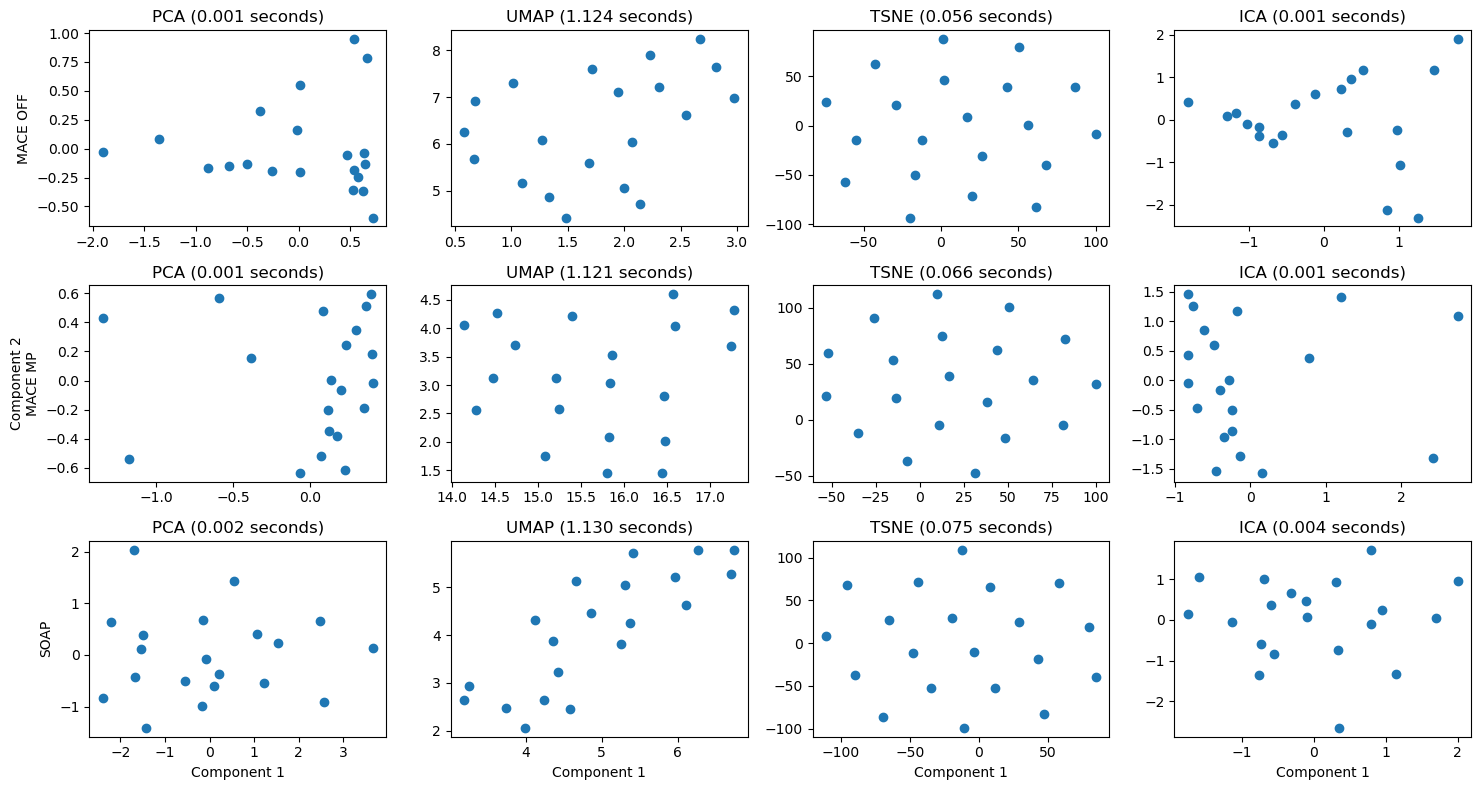

In [126]:
fig, axes = plt.subplots(len(descriptors), len(methods), figsize=(15, 8))

for i, descriptors in enumerate(descriptors):
    descriptor_name = descriptor_names[i]
    print(descriptor_name)

    for j, method in enumerate(methods):
        ax = axes[i, j]
        X_reduced, execution_time = dimensionality_reduction_analysis(
            descriptors, method=method
        )

        ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
        ax.set_title(f"{method} ({execution_time:.3f} seconds)")
        if i == 2:  # Last row
            ax.set_xlabel("Component 1")
        if j == 0 and i == 1:  # First column
            ax.set_ylabel(f"Component 2\n{descriptor_name}")
        elif j == 0:
            ax.set_ylabel(descriptor_name)

    print("")

plt.tight_layout()
plt.show()

#### Dimensionality reduction on the concatenated features

In [148]:
concatenated_features = np.concatenate(
    (mace_off_features, mace_mp_features, soap_features), axis=1
)

PCA execution time: 0.00 seconds
UMAP execution time: 1.17 seconds
TSNE execution time: 0.06 seconds
ICA execution time: 0.00 seconds


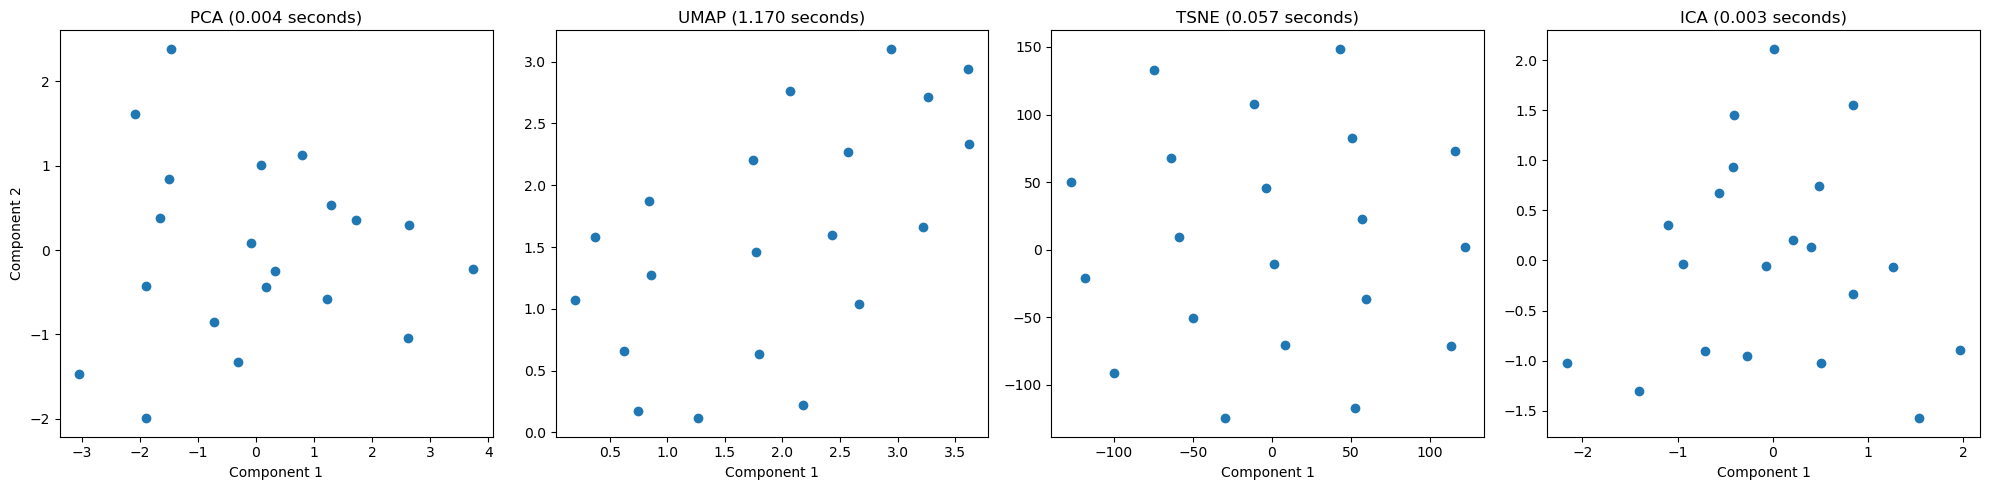

In [153]:
fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))

for j, method in enumerate(methods):
    ax = axes[j]
    X_reduced, execution_time = dimensionality_reduction_analysis(
        concatenated_features, method
    )
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1])
    ax.set_title(f"{method} ({execution_time:.3f} seconds)")
    ax.set_xlabel("Component 1")
    if j == 0:
        ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### Dimensionality Reduction on whole dataset

Load precomputed descriptors

In [155]:
mace_mp_features_file = os.path.join("data", "descriptors_MACE_MP0_all.npy")
mace_mp_features = np.load(mace_mp_features_file)

mace_off_features_file = os.path.join("data", "descriptors_MACE_OFF_all.npy")
mace_off_features = np.load(mace_off_features_file)

soap_features_file = os.path.join("data", "descriptors_SOAP_all.npy")
soap_features = np.load(soap_features_file)

Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...
Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...
Loading existing reducer and points for PCA...
Loading existing reducer and points for UMAP...
Loading existing reducer and points for TSNE...
Loading existing reducer and points for ICA...


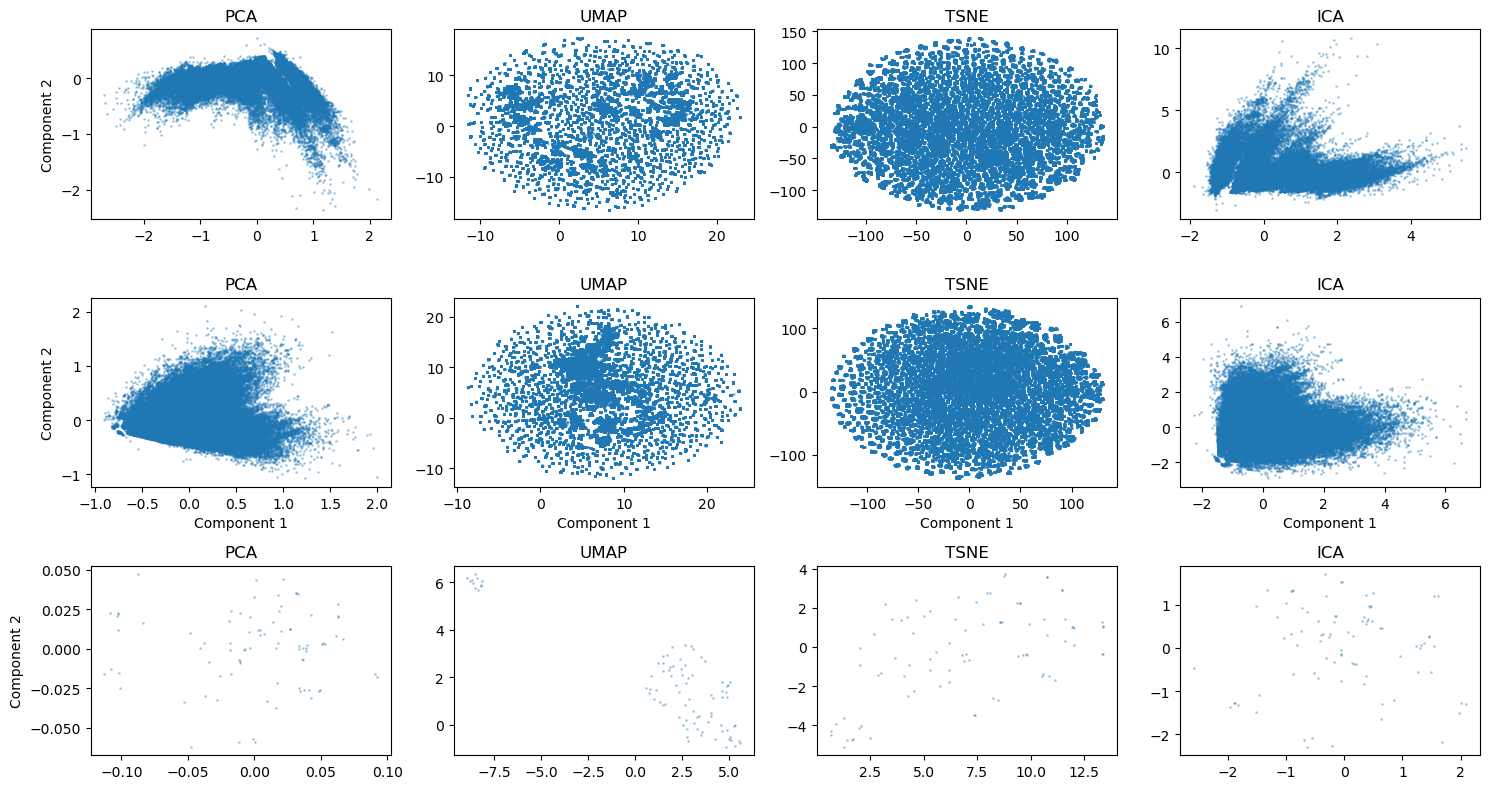

In [156]:
descriptors = [mace_off_features, mace_mp_features, soap_features]
descriptor_names = ["mace_off", "mace_mp", "soap"]

fig, axes = plt.subplots(len(descriptors), len(methods), figsize=(15, 8))

for i, descriptors in enumerate(descriptors):
    for j, method in enumerate(methods):
        ax = axes[i, j]

        print(f"Loading existing reducer and points for {method}...")
        descriptor = descriptor_names[i]
        reducer_path = os.path.join("data", f"{method}_{descriptor}_reducer.pkl")
        points_path = os.path.join("data", f"{method}_{descriptor}_points.npy")

        reducer = joblib.load(reducer_path)
        X_reduced = np.load(points_path)

        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.3, s=1)
        ax.set_title(method)
        if i == 1:
            ax.set_xlabel("Component 1")
        if j == 0:
            ax.set_ylabel("Component 2")

plt.tight_layout()
plt.show()

### Chemiscope Visualisation

Extracting all properties

In [336]:
def get_properties(frames):
    properties_structure = {}

    for frame in frames:
        for prop, value in frame.info.items():
            # if prop in ['index', 'A', 'B', 'C', 'mu', 'alpha', 'homo']:
            if prop != "frequencies":
                structure_entry = properties_structure.setdefault(
                    prop, {"target": "structure", "values": []}
                )
                structure_entry["values"].append(value)

    return properties_structure

In [337]:
properties = get_properties(frames)

In [339]:
chemiscope.show(frames, properties, meta={"name": "QM9 MACE OFF features"})

<ChemiscopeWidget(meta={'name': 'QM9 MACE OFF features'}, structures=[{'size': 5, 'names': ['C', 'H', 'H', 'H'…

### Methods separately

In [157]:
def show_plt(data, method_name, features_name):
    plt.scatter(data[:, 0], data[:, 1], alpha=0.1, s=1)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"{method_name} of {features_name} Features")
    plt.show()

#### PCA

In [132]:
from sklearn.decomposition import PCA


def apply_pca(descriptors):
    return PCA(n_components=2).fit_transform(descriptors)

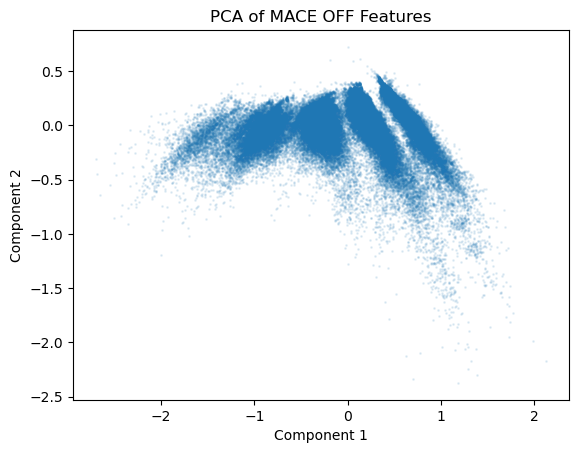

In [133]:
X_pca_mace_off = apply_pca(mace_off_features)

show_plt(X_pca_mace_off, method_name="PCA", features_name="MACE OFF")

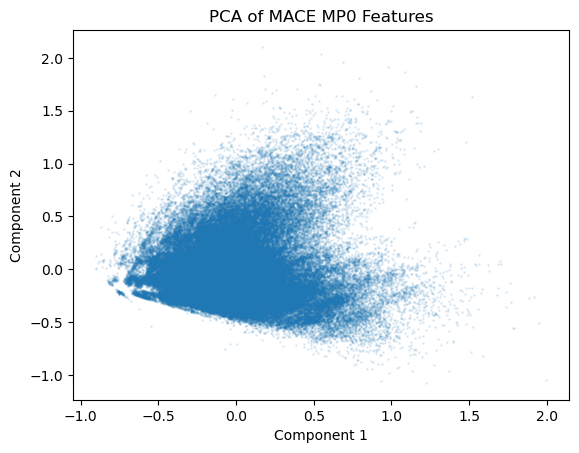

In [134]:
X_pca_mace_mp = apply_pca(mace_mp_features)

show_plt(X_pca_mace_mp, method_name="PCA", features_name="MACE MP0")

#### UMAP

In [135]:
import umap


def apply_umap(descriptors):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        target_metric="categorical",
    )
    return reducer.fit_transform(descriptors)

In [136]:
X_umap_mace_off = apply_umap(mace_off_features)

show_plt(X_umap_mace_off, method_name="UMAP", features_name="MACE OFF")

KeyboardInterrupt: 

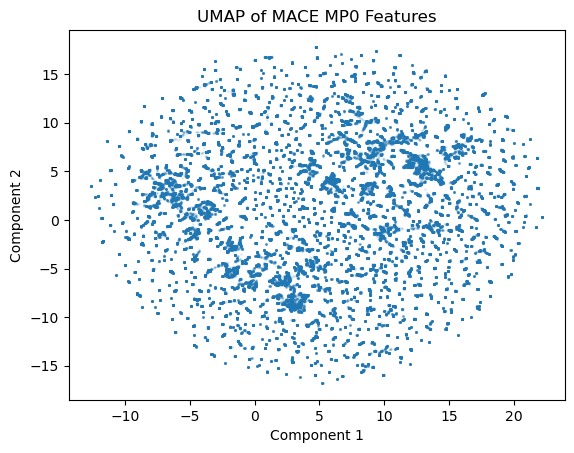

In [ ]:
X_umap_mace_mp = apply_umap(mace_off_features)

show_plt(X_umap_mace_mp, method_name="UMAP", features_name="MACE MP0")

#### TSNE

In [ ]:
from sklearn.manifold import TSNE


def apply_tsne(descriptors):
    return TSNE(n_components=2).fit_transform(descriptors)

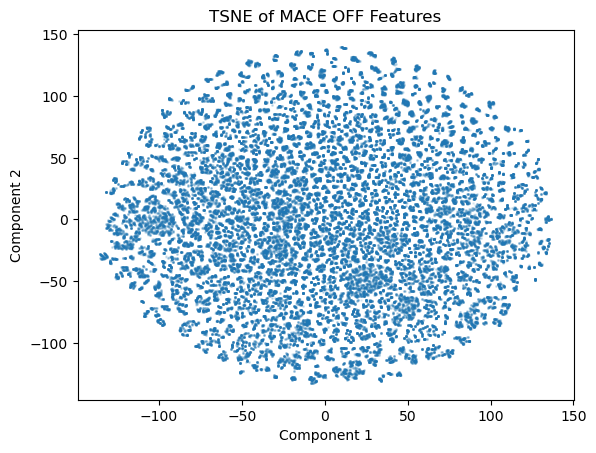

In [ ]:
X_tsne_mace_off = apply_tsne(mace_off_features)

show_plt(X_tsne_mace_off, method_name="TSNE", features_name="MACE OFF")

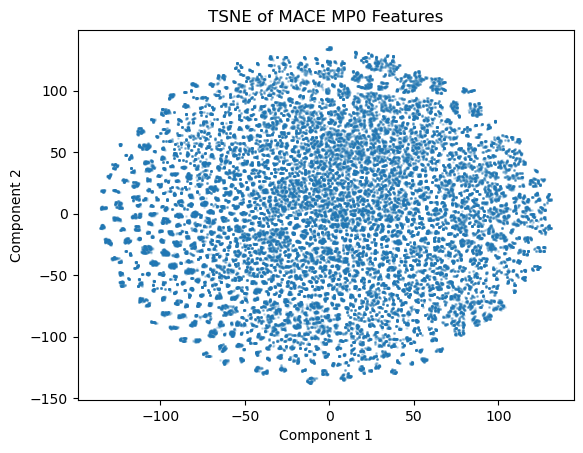

In [ ]:
X_tsne_mace_mp = apply_tsne(mace_mp_features)

show_plt(X_tsne_mace_mp, method_name="TSNE", features_name="MACE MP0")

#### ICA

In [ ]:
from sklearn.decomposition import FastICA


def apply_ica(descriptors):
    reducer = FastICA(n_components=2)
    return reducer.fit_transform(descriptors)

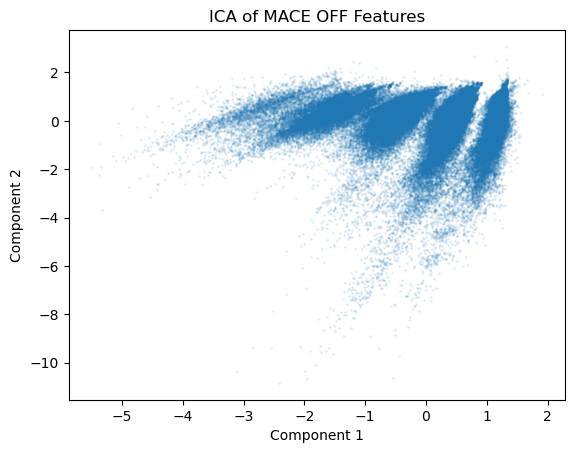

In [ ]:
X_ica_mace_off = apply_ica(mace_off_features)

show_plt(X_ica_mace_off, method_name="ICA", features_name="MACE OFF")

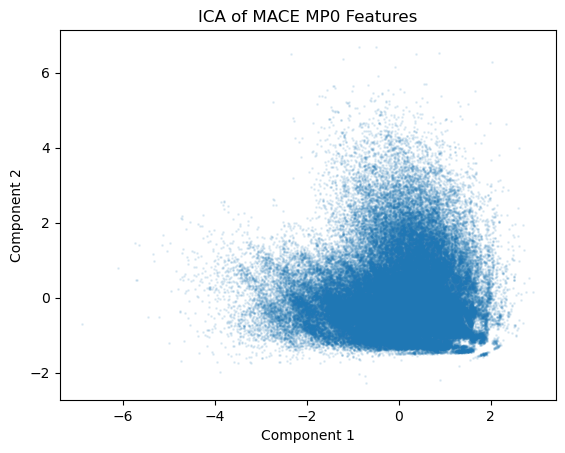

In [ ]:
X_ica_mace_mp = apply_ica(mace_mp_features)

show_plt(X_ica_mace_mp, method_name="ICA", features_name="MACE MP0")

#### SOAP

In [ ]:
from itertools import islice


def batched(iterable, n):
    "Batch data into tuples of length n. The last batch may be shorter."
    if n < 1:
        raise ValueError("n must be at least one")
    it = iter(iterable)
    while batch := tuple(islice(it, n)):
        yield batch

In [ ]:
hypers_ps = {
    "cutoff": 5.0,
    "max_radial": 6,
    "max_angular": 6,
    "atomic_gaussian_width": 0.3,
    "center_atom_weight": 0.0,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "ShiftedCosine": {"width": 0.5},
    },
    "radial_scaling": {"Willatt2018": {"exponent": 7.0, "rate": 1.0, "scale": 2.0}},
}

calculator = SoapPowerSpectrum(**hypers_ps)

In [ ]:
for batch in batched(frames, 100):
    feat = calculator.compute(batch)

In [ ]:
# feat = calculator.compute(frames)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f1f797fe710>>
Traceback (most recent call last):
  File "/home/chorna/miniconda3/envs/chemiscope_auto/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
feat = feat.keys_to_samples(["center_type"])
feat = feat.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])

feat = mean_over_samples(feat, sample_names=["atom", "center_type"])

Xfeat = feat.block(0).values